In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
import math

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact_manual

plotting_backend = "plotly-static"

In [79]:
df=pd.read_csv("Load_in_Great_Britain.csv")
df.columns = ['ds', 'y']
df.shape

(6395, 2)

In [4]:
fig = px.line(df, x=df["ds"], y=df["y"])
fig.show()

## Neural Prophet

In [5]:
quantiles = [0.015, 0.985]

params = {
    "n_lags": 24,
    "n_forecasts": 7,
    "n_changepoints": 20,
    "learning_rate": 0.01,
    "ar_layers": [32, 16, 16, 32],
    "epochs": 70,
    "batch_size": 64,
    "quantiles": quantiles,
}


m = NeuralProphet(**params)
m.set_plotting_backend(plotting_backend)
set_log_level("ERROR")

In [6]:
df_train, df_test = m.split_df(df, valid_p=0.1, local_split=True)
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (5916, 2)
Test shape: (684, 2)


In [14]:
metrics_fit = m.fit(df_train, freq="D", metrics=True)

Training: 0it [00:00, ?it/s]

In [15]:
forecast = m.predict(df_test)

Predicting: 92it [00:00, ?it/s]

In [16]:
fig = go.Figure()
fig.update_layout(title="Neural Prophet with GB Load values")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat1'], mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"])}')
print(f'RMSE : {math.sqrt(mean_squared_error(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"]))}')
print(f'MAE : {mean_absolute_error(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"])}')

R2 Score : 0.9750144349172014
RMSE : 26.249500757965563
MAE : 20.243562653209466


## LSTM

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
 
n_input = 24
n_features = 1
generator = TimeseriesGenerator(df_train['y'],
                                df_train['y'],
                                length=n_input,
                                batch_size=32)
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 638.5  578.   565.5  540.   500.5  479.5  484.   525.5  579.5  632.
  690.   765.5  838.5  919.5  962.   951.5  985.  1018.5 1074.5  993.
  903.   848.5  797.5  742.   578.   565.5  540.   500.5  479.5  484.
  525.5  579.5  632.   690.   765.5  838.5  919.5  962.   951.5  985.
 1018.5 1074.5  993.   903.   848.5  797.5  742.   672.5  565.5  540.
  500.5  479.5  484.   525.5  579.5  632.   690.   765.5  838.5  919.5
  962.   951.5  985.  1018.5 1074.5  993.   903.   848.5  797.5  742.
  672.5  597.5  540.   500.5  479.5  484.   525.5  579.5  632.   690.
  765.5  838.5  919.5  962.   951.5  985.  1018.5 1074.5  993.   903.
  848.5  797.5  742.   672.5  597.5  561.5  500.5  479.5  484.   525.5
  579.5  632.   690.   765.5  838.5  919.5  962.   951.5  985.  1018.5
 1074.5  993.   903.   848.5  797.5  742.   672.5  597.5  561.5  540.5
  479.5  484.   525.5  579.5  632.   690.   765.5  838.5  919.5  962.
  951.5  985.  1018.5 1074.5  993.   903.   848.5  797.5  742.   672

In [71]:
# define model
model = Sequential()
model.add(LSTM(40, activation='relu',
               input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mae')
model.summary()
history = model.fit(generator, epochs=40)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 40)                6720      
                                                                 
 dense_11 (Dense)            (None, 1)                 41        
                                                                 
Total params: 6761 (26.41 KB)
Trainable params: 6761 (26.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
185/185 [==============================] - 3s 7ms/step - loss: 628.3917
Epoch 2/40
185/185 [==============================] - 1s 7ms/step - loss: 189.0605
Epoch 3/40
185/185 [==============================] - 1s 7ms/step - loss: 162.5458
Epoch 4/40
185/185 [==============================] - 1s 7ms/step - loss: 170.5125
Epoch 5/40
185/185 [==============================] - 1s 7ms/step - loss: 155.6205


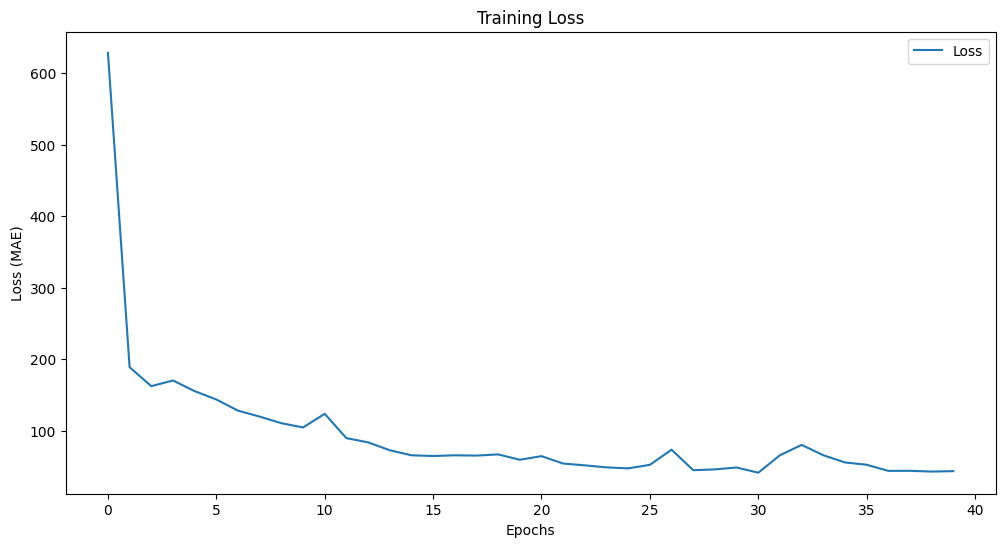

In [72]:
import matplotlib.pyplot as plt
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [73]:
n_input = 24
n_features = 1
test_generator = TimeseriesGenerator(df['y'],
                                df['y'],
                                length=n_input,
                                batch_size=32)
out=model.predict(test_generator)

200/200 [==============================] - 1s 3ms/step


In [74]:
out_test=out[df.shape[0]-df_test.shape[0]-n_input:]
out_test.reshape(-1).shape

(684,)

In [75]:
fig = go.Figure()
fig.update_layout(title="LSTM with GB ")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=df_test['ds'], y=out_test.reshape(-1), mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [76]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(df_test.y,out[df.shape[0]-df_test.shape[0]-n_input:])}')
print(f'RMSE : {math.sqrt(mean_squared_error(df_test.y,out[df.shape[0]-df_test.shape[0]-n_input:]))}')
print(f'MAE : {mean_absolute_error(df_test.y,out[df.shape[0]-df_test.shape[0]-n_input:])}')

R2 Score : -0.41117713858677596
RMSE : 197.95018965173335
MAE : 153.36349301794922


In [78]:
model.save("lstm_load.keras")

## ARIMA

In [80]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [81]:
def grid_search_arima(data, p_range, d_range, q_range):
    best_score = float('inf')
    best_order = None
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(data, order=(p,d,q))
                    results = model.fit()
                    aic = results.aic
                    if aic < best_score:
                        best_score = aic
                        best_order = (p,d,q)
                except:
                    continue
    return best_order

def rolling_arima_predictions(train_data, test_data, order):
    predictions = []
    history = list(train_data)
    for t in range(len(test_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)[0]
        
        predictions.append(pred)
        history.append(test_data[t])
    return np.array(predictions)

In [82]:
best_order = grid_search_arima(df_train['y'], 
                             p_range=range(0,3), 
                             d_range=range(0,2), 
                             q_range=range(0,3))
print(f"Best ARIMA order: {best_order}")

Best ARIMA order: (2, 1, 2)


In [83]:
import pickle
with open("model_store/best_order_load.pkl", "wb") as f:
    pickle.dump(best_order, f)

In [96]:
arima_preds = rolling_arima_predictions(df_train['y'].values, df_test['y'].values, best_order)

In [97]:
fig = go.Figure()
fig.update_layout(title="Rolling ARIMA with GB")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=df_test['ds'], y=arima_preds.reshape(-1), mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [98]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(df_test.y,arima_preds)}')
print(f'RMSE : {math.sqrt(mean_squared_error(df_test.y,arima_preds))}')
print(f'MAE : {mean_absolute_error(df_test.y,arima_preds)}')

R2 Score : 0.961717605398738
RMSE : 32.603536002357735
MAE : 25.243109214035734


## HMM

In [84]:
from hmmlearn import hmm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [85]:
K = 24
NUM_ITERS = 100
STATE_SPACE = range(2, 16)

In [86]:
def get_optimal_states(original_dataset, NUM_ITERS, STATE_SPACE):
    # data = original_dataset[1:]-original_dataset[:original_dataset.shape[0]-1]
    data=original_dataset
    likelihood_vect, aic_vect, bic_vect = [], [], []
    for states in STATE_SPACE:
        model = hmm.GaussianHMM(n_components=states, covariance_type='diag', tol=0.0001, n_iter=NUM_ITERS)
        model.fit(data)
        scr = model.score(data)
        sts_c = (states**2 + states)
        likelihood_vect.append(scr)
        aic_vect.append(-2 * scr + 2 * sts_c)
        bic_vect.append(-2 * scr + sts_c * np.log(data.shape[0]))
    opt_states = np.argmin(bic_vect) + 2
    print(f'Optimum number of states: {opt_states}')
    return opt_states

def rolling_hmm(original_dataset, original_test_dataset, opt_states, NUM_ITERS):
    # train_data = original_dataset[1:]-original_dataset[:original_dataset.shape[0]-1]
    # test_data = original_test_dataset[1:]-original_test_dataset[:original_test_dataset.shape[0]-1]
    train_data = original_dataset
    test_data = original_test_dataset
    predictions = []
    history = train_data
    for t in range(len(test_data)):
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='diag', tol=0.0001, n_iter=NUM_ITERS)
        model.fit(history)
        hidden_states = model.predict(history)
        last_hidden_state = hidden_states[-1]
        next_state_probs = model.transmat_[last_hidden_state]
        predicted_state = np.argmax(next_state_probs)
        predicted_change = model.means_[predicted_state][0] #change prediction
        pred = predicted_change
        # pred = original_dataset[-2]+predicted_change #calculation of new price from previous price
        predictions.append(pred)
        history = np.append(history, test_data[t]).reshape(-1,1)
        original_dataset = np.append(original_dataset, original_test_dataset[t])

    predictions.append(pred)

    return predictions

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(np.array(df['y']).reshape(-1,1))

StandardScaler()

In [88]:
train_array = np.array(df_train['y']).reshape(-1,1)
train_scaled = scaler.transform(train_array)
test_array = np.array(df_test['y']).reshape(-1,1)
test_scaled = scaler.transform(test_array)

In [89]:
o_states = get_optimal_states(train_scaled, NUM_ITERS, STATE_SPACE)

Optimum number of states: 14


In [91]:
import pickle
with open("model_store/opt_no_states_load.pkl", "wb") as f:
    pickle.dump(o_states, f)

In [ ]:
hmm_preds = rolling_hmm(train_scaled, test_scaled, o_states, NUM_ITERS) #45 minutes

In [ ]:
p1=scaler.inverse_transform(np.array(hmm_preds).reshape(-1,1))
hmm_preds = p1.reshape(-1)[:p1.shape[0]-1]

In [92]:
fig = go.Figure()
fig.update_layout(title="Rolling HMM with GB")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=df_test['ds'], y=hmm_preds, mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [90]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(df_test.y,hmm_preds)}')
print(f'RMSE : {math.sqrt(mean_squared_error(df_test.y,hmm_preds))}')
print(f'MAE : {mean_absolute_error(df_test.y,hmm_preds)}')

R2 Score : 0.8443464272171632
RMSE : 65.7422711007105
MAE : 49.95234962117391
